<img src="https://gitlab.inf.unibz.it/earth_observation_public/eurac-openeo-examples/-/raw/main/python/aux_data/eurac_EO.png"
     alt="EURAC EO logo"
     style="float: left; margin-right: 10px; max-width: 300px" />

# Land Cover Classification - Part 2

Author michele.claus@eurac.edu

Date: 2023/09/12

During this exercise we will perform a land cover classification task using open source software and data.

## 1. Training Dataset Generation

### 1.1 Corine Land Cover data via openEO
This time we will use the Corine Land Cover layer and sample random points from it.

We get the bbox from the previous exercise:

In [1]:
import numpy as np
bbox = np.array([11.29689773, 46.45952576, 11.37833251, 46.50871696])

Download the Corine Land Cover data for the area of interest.

In [2]:
import openeo
openeoHost = "openeo.eurac.edu"
conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")
collection      = "ADO_CORINE_100m_3035_ODC"
spatial_extent =  {"west": bbox[0], "south": bbox[1], "east": bbox[2], "north": bbox[3]}

conn.load_collection(collection,spatial_extent=spatial_extent).download("corine_land_cover_openeo.nc")

Authenticated using refresh token.


Restructure the netCDF to an xArray Dataset and store it in another file:

In [3]:
import xarray as xr
clc_ds = xr.open_dataarray("corine_land_cover_openeo.nc",decode_coords="all")[:,0].to_dataset(dim="variable")
clc_ds.to_netcdf("corine_land_cover_ds.nc")

Open the result and visualize it

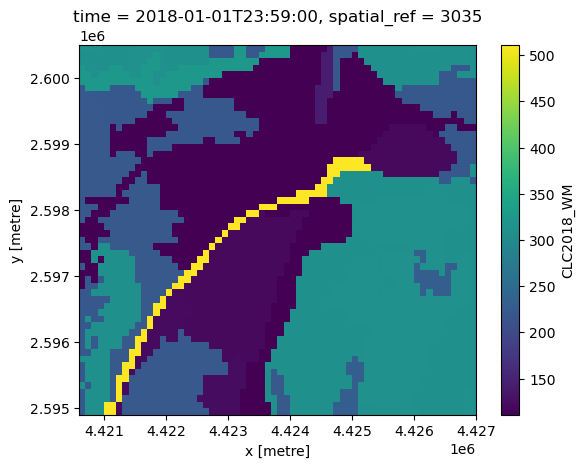

In [4]:
clc_data = xr.open_dataset("corine_land_cover_ds.nc")
clc_data.CLC2018_WM.plot.imshow()

What are the land cover classes in our AOI? You can get the class number - description correspondence from here: https://wiki.openstreetmap.org/wiki/Corine_Land_Cover

In [5]:
np.unique(clc_data.CLC2018_WM)

array([111., 112., 121., 122., 124., 142., 221., 222., 231., 311., 312.,
       313., 324., 511.])

What is the Corine data projection?

In [6]:
clc_data.crs

'EPSG:3035'

### 1.2 Training dataset alignment

We previously generated a dataset for Sentinel-2 and one for Sentinel-1. However, they both have a different projection compared to the Corine layer.

Therefore, we want to use openEO again (but this time locally) to align all the input datasets before proceeding.

In [7]:
from openeo.local import LocalConnection
local_conn = LocalConnection("./")
local_conn.list_collections()

[{'stac_version': '1.0.0-rc.2',
  'type': 'Collection',
  'id': 'corine_land_cover.nc',
  'title': 'corine_land_cover.nc',
  'description': '',
  'license': '',
  'providers': [{'name': '', 'roles': ['producer'], 'url': ''}],
  'links': '',
  'extent': {'temporal': {'interval': [['2018-01-01T23:59:00.000000000',
      '2018-01-01T23:59:00.000000000']]}},
  'cube:dimensions': {'time': {'type': 'temporal',
    'extent': ['2018-01-01T23:59:00.000000000',
     '2018-01-01T23:59:00.000000000']},
   'x': {'type': 'spatial', 'axis': 'x', 'extent': [4420650.0, 4426950.0]},
   'y': {'type': 'spatial', 'axis': 'y', 'extent': [2594950.0, 2600450.0]},
   'bands': {'type': 'bands', 'values': ['__xarray_dataarray_variable__']}}},
 {'stac_version': '1.0.0-rc.2',
  'type': 'Collection',
  'id': 'corine_land_cover_ds.nc',
  'title': 'corine_land_cover_ds.nc',
  'description': '',
  'license': '',
  'providers': [{'name': '', 'roles': ['producer'], 'url': ''}],
  'links': '',
  'extent': {},
  'cube:dimensions': {'x': {'type': 'spatial',
    'axis': 'x',
    'extent': [4420650.0, 4426950.0]},
   'y': {'type': 'spatial', 'axis': 'y', 'extent': [2594950.0, 2600450.0]},
   'bands': {'type': 'bands', 'values': ['CLC2018_WM']}}},
 {'stac_version': '1.0.0-rc.2',
  'type': 'Collection',
  'id': 'corine_land_cover_openeo.nc',
  'title': 'corine_land_cover_openeo.nc',
  'description': '',
  'license': '',
  'providers': [{'name': '', 'roles': ['producer'], 'url': ''}],
  'links': '',
  'extent': {'temporal': {'interval': [['2018-01-01T23:59:00.000000000',
      '2018-01-01T23:59:00.000000000']]}},
  'cube:dimensions': {'time': {'type': 'temporal',
    'extent': ['2018-01-01T23:59:00.000000000',
     '2018-01-01T23:59:00.000000000']},
   'x': {'type': 'spatial', 'axis': 'x', 'extent': [4420650.0, 4426950.0]},
   'y': {'type': 'spatial', 'axis': 'y', 'extent': [2594950.0, 2600450.0]},
   'bands': {'type': 'bands', 'values': ['__xarray_dataarray_variable__']}}},
 {'stac_version': '1.0.0-rc.2',
  'type': 'Collection',
  'id': 'sentinel_1_2022.nc',
  'title': 'sentinel_1_2022.nc',
  'description': '',
  'license': '',
  'providers': [{'name': '', 'roles': ['producer'], 'url': ''}],
  'links': '',
  'extent': {'temporal': {'interval': [['2022-06-30T00:00:00.000000000',
      '2022-08-31T00:00:00.000000000']]}},
  'cube:dimensions': {'time': {'type': 'temporal',
    'extent': ['2022-06-30T00:00:00.000000000',
     '2022-08-31T00:00:00.000000000']},
   'x': {'type': 'spatial', 'axis': 'x', 'extent': [665445.0, 691475.0]},
   'y': {'type': 'spatial', 'axis': 'y', 'extent': [5139225.0, 5160765.0]},
   'bands': {'type': 'bands', 'values': ['VH', 'VV', 'spatial_ref']}}},
 {'stac_version': '1.0.0-rc.2',
  'type': 'Collection',
  'id': 'sentinel_1_radar_mask.nc',
  'title': 'sentinel_1_radar_mask.nc',
  'description': '',
  'license': '',
  'providers': [{'name': '', 'roles': ['producer'], 'url': ''}],
  'links': '',
  'extent': {},
  'cube:dimensions': {'x': {'type': 'spatial',
    'axis': 'x',
    'extent': [665445.0, 691475.0]},
   'y': {'type': 'spatial', 'axis': 'y', 'extent': [5139225.0, 5160765.0]},
   'bands': {'type': 'bands',
    'values': ['VV', 'foreshortening', 'layover', 'shadow', 'spatial_ref']}}},
 {'stac_version': '1.0.0-rc.2',
  'type': 'Collection',
  'id': 'sentinel_2_2022.nc',
  'title': 'sentinel_2_2022.nc',
  'description': '',
  'license': '',
  'providers': [{'name': '', 'roles': ['producer'], 'url': ''}],
  'links': '',
  'extent': {'temporal': {'interval': [['2022-06-30T00:00:00.000000000',
      '2022-08-31T00:00:00.000000000']]}},
  'cube:dimensions': {'time': {'type': 'temporal',
    'extent': ['2022-06-30T00:00:00.000000000',
     '2022-08-31T00:00:00.000000000']},
   'x': {'type': 'spatial', 'axis': 'x', 'extent': [676220.0, 682620.0]},
   'y': {'type': 'spatial', 'axis': 'y', 'extent': [5147670.0, 5153320.0]},
   'bands': {'type': 'bands', 'values': ['B04', 'B03', 'B02', 'B08']}}},
 {'stac_version': '1.0.0-rc.2',
  'type': 'Collection

#### 1.2.1 Load the input datasets

In [8]:
s2 = local_conn.load_collection("sentinel_2_2022.nc")
s1 = local_conn.load_collection("sentinel_1_2022.nc")
clc = local_conn.load_collection("corine_land_cover_ds.nc")
radar_mask = local_conn.load_collection("sentinel_1_radar_mask.nc")

#### 1.2.2 Apply the Sentinel-1 radar mask

In [9]:
bool_mask = (radar_mask.band("layover") == 0) & (radar_mask.band("shadow") == 0)
s1_masked = s1.merge_cubes(bool_mask,overlap_resolver="multiply")

#### 1.2.3 Align the datasets

In [10]:
s1_aligned = s1_masked.resample_cube_spatial(target=s2,method="near")
clc_aligned = clc.resample_cube_spatial(target=s2,method="near")

#### 1.2.4 Merge s2 and s1 in one datacube

In [11]:
s2_s1 = s2.merge_cubes(s1_aligned)

#### 1.2.5 Execute the openEO process graphs and get xArray

In [157]:
s2_s1_xr = s2_s1.execute()
clc_xr = clc_aligned.execute()
clc_xr = clc_xr.where(clc_xr!=clc_xr.attrs["_FillValue"],0)

In [158]:
clc_xr.rio.to_raster("corine_aligned.tif")

### 1.2 Random Points generation

We will generate random points used for training, starting from the bounds of our AOI.

#### 1.2.1 Generate a Polygon given the AOI coordinates

In [13]:
import geopandas as gpd
from shapely import Polygon, Point, MultiPoint
polygon = Polygon([[bbox[0], bbox[1]], [bbox[0], bbox[3]], [bbox[2], bbox[3]], [bbox[2], bbox[1]]])
gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon])
gdf

,geometry
0,"POLYGON ((11.29690 46.45953, 11.29690 46.50872..."


#### 1.2.2 Define a function to draw random points

In [14]:
import random
import geopandas as gpd
from geopandas import GeoDataFrame
import pandas as pd
from typing import Optional

def random_points(gdf: GeoDataFrame, total_count:Optional[int] = 100, seed:Optional[int] = 0):
    random.seed(seed)
    points_gdf = None
    # Loop over all the Polygons:
    for idx, polygon in gdf.iterrows():
        # find area bounds
        bounds = polygon.geometry.bounds
        xmin, ymin, xmax, ymax = bounds
        xext = xmax - xmin
        yext = ymax - ymin
        count = 0
        points_list = []
        for i in range(total_count):
            # generate a random x and y
            x = xmin + random.random() * xext
            y = ymin + random.random() * yext
            p = Point(x, y)
            if polygon.geometry.contains(p):  # check if point is inside geometry
                if points_gdf is None:
                    points_gdf = gpd.GeoDataFrame(index=[count], crs='epsg:4326', geometry=[p])
                else:
                    points_gdf = pd.concat([points_gdf,gpd.GeoDataFrame(index=[count], crs='epsg:4326', geometry=[p])])
                count += 1
    return points_gdf # This returns a GeoDataframe (geopandas)

#### 1.2.3 Draw random points

In [15]:
candidate_sampling_points = random_points(gdf,5000)

Save the points in a geoJSON file for inspection

In [16]:
candidate_sampling_points.to_file("candidate_sampling_points.json", driver="GeoJSON")  

Reproject the points to the common crs of the data

In [17]:
candidate_samp_pts_reproj = candidate_sampling_points.to_crs(s2_s1_xr.crs)

In [18]:
candidate_samp_pts_reproj.head(3)

,geometry
0,POINT (681529.777 5151967.943)
1,POINT (678961.769 5149161.561)
2,POINT (679505.173 5149976.412)


### 1.3 Sampling Points Filtering

#### 1.3.1 Assign Corine class to points
Given the random points generated over our AOI, we now want to extract the corresponding Corine class for each point.

In [19]:
labels = []
for idx,s in enumerate(candidate_samp_pts_reproj.iterrows()):
    point = s[1]["geometry"]
    label = clc_xr.sel(x=point.x,y=point.y,method='nearest').values[0]
    labels.append(label)
candidate_samp_pts_reproj = candidate_samp_pts_reproj.assign(**{"label":labels})

In [20]:
candidate_samp_pts_reproj.head(3)

,geometry,label
0,POINT (681529.777 5151967.943),121.0
1,POINT (678961.769 5149161.561),121.0
2,POINT (679505.173 5149976.412),121.0


#### 1.3.2 Feature Vector extraction, given a priori knowledge

Since the source Corine layer has a resolution of 100 meters and our data of 10 meters, it is possible that a pixel classified as, for example, water it is not in reality.

Additionally, the Corine layer was generated in 2018, but our data is from 2022.

Many reasons telling us how important it is to understand the data we are using, before even using it.

Improving the training data and applying a priori knowledge for obtaining the best samples is a key step to get the most out of your dataset and model.

In this case, we can for example:

- Generally if either the VV or VH values of Sentinel-1 are zero. This means that the selected point is in a masked area and we can't use it.
- For the water class, we can compute the NDWI (Normalized Difference Water Index) and check its value. If NDWI > 0 we keep the sample.

There are more indexes we could use for filtering, like NDVI (Vegetation Index), NDBI (Built up Index), NDSI (Snow Index).

In [32]:
valid_points = None
masked_points = None
not_water_points = None

predictors = []
labels = []
count_valid_points = 0
count_masked = 0
count_not_water = 0

for idx,s in enumerate(candidate_samp_pts_reproj.iterrows()):
    point = s[1]["geometry"]
    label = s[1]["label"]
    px_data = s2_s1_xr.sel(x=point.x,y=point.y,method='nearest')
    if px_data.loc[dict(bands="VV")].all() == 0:
        # Radar masked data, skip it
        if masked_points is None:
            masked_points = gpd.GeoDataFrame(index=[count_masked], geometry=[point])
        else:
            masked_points = pd.concat([masked_points,gpd.GeoDataFrame(index=[count_masked], geometry=[point])])
            count_masked += 1
        continue
    if label==511 or label==512: # Corine Water Courses and Water Bodies
        # Check the NDWI value (green - nir)/(green + nir)
        green = px_data.loc[dict(bands="B03")]
        nir = px_data.loc[dict(bands="B08")]
        NDWI = (green - nir)/(green + nir)
        if np.min(NDWI) < 0:
            if not_water_points is None:
                not_water_points = gpd.GeoDataFrame(index=[count_not_water], geometry=[point])
            else:
                not_water_points = pd.concat([not_water_points,gpd.GeoDataFrame(index=[count_not_water], geometry=[point])])
            count_not_water += 1
            continue
    if valid_points is None:
        valid_points = gpd.GeoDataFrame(index=[count_valid_points], geometry=[point])
    else:
        valid_points = pd.concat([valid_points,gpd.GeoDataFrame(index=[count_valid_points], geometry=[point])])
    count_valid_points += 1
    feature_vector = list(np.ndarray.flatten(px_data.values))
    predictors.append(feature_vector)
    labels.append(label)


In [36]:
valid_points = valid_points.assign(**{"features":predictors})
valid_points = valid_points.assign(**{"label":labels})

In [27]:
# valid_points.to_file("valid_points.json", driver="GeoJSON")  
masked_points.set_crs(s2_s1_xr.crs,allow_override=True).to_crs(4326).to_file("masked_points.json", driver="GeoJSON")  
not_water_points.set_crs(s2_s1_xr.crs,allow_override=True).to_crs(4326).to_file("not_water_points.json", driver="GeoJSON")  

#### 1.3.2 Count the valid samples for each class

In [47]:
classes = np.unique(valid_points["label"])
for c in classes:
    n_samples = len(valid_points[valid_points["label"]==c])
    print(f"Class {c} has {n_samples} samples.")

Class 111.0 has 418 samples.
Class 112.0 has 884 samples.
Class 121.0 has 530 samples.
Class 122.0 has 74 samples.
Class 124.0 has 65 samples.
Class 142.0 has 44 samples.
Class 221.0 has 366 samples.
Class 222.0 has 546 samples.
Class 231.0 has 54 samples.
Class 311.0 has 676 samples.
Class 312.0 has 151 samples.
Class 313.0 has 543 samples.
Class 324.0 has 129 samples.
Class 511.0 has 34 samples.


#### 1.3.3 Keep a limited number of samples per class

In [50]:
max_samples_per_class = 100
subset_samples = None
for c in classes:
    if subset_samples is None:
        subset_samples = valid_points[valid_points["label"]==c][:max_samples_per_class]
    else:
        subset_samples = pd.concat([subset_samples,valid_points[valid_points["label"]==c][:max_samples_per_class]])

We perform some operations to:
1. Get the feature vector in the desired shape: NxM with N as the number of points and M the number of features (in this case bands*time)
2. Get the corresponding label vector with the correct format. The ML library we are using is expecting labels with values starting from 0 and therefore we have to map them.

In [54]:
from sklearn.preprocessing import LabelEncoder

x_train = np.asarray([x for x in subset_samples["features"].values])

le = LabelEncoder()
y_train = le.fit_transform(subset_samples["label"].values)

In [68]:
dict_mapping = {}
[dict_mapping.update({x:l}) for x,l in enumerate(np.unique(subset_samples["label"].values))]
dict_mapping

{0: 111.0,
 1: 112.0,
 2: 121.0,
 3: 122.0,
 4: 124.0,
 5: 142.0,
 6: 221.0,
 7: 222.0,
 8: 231.0,
 9: 311.0,
 10: 312.0,
 11: 313.0,
 12: 324.0,
 13: 511.0}

## 2 Random Forest

We use the xgboost ML library with its Random Forest implementation.

For more info please read the documentation here:

https://xgboost.readthedocs.io/en/stable/tutorials/rf.html#standalone-random-forest-with-scikit-learn-like-api

and for the colsample_by* hyperparameters explanation check this nice article here:

https://medium.com/analytics-vidhya/xgboost-colsample-by-hyperparameters-explained-6c0bac1bdc1

### 2.1 Model training

In [56]:
from xgboost import XGBRFClassifier
model = XGBRFClassifier(n_estimators=100, subsample=0.9,random_state=0)
model.fit(x_train, y_train)

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                objective='multi:softprob', predictor=None, random_state=0,
                reg_alpha=None, ...)

### 2.2 Model prediction

To speed up the prediction process, we parallelize using xarray `apply_ufunc`, which allows to apply the same function call to multiple data chunks in parallel using Dask.

In [100]:
import xarray as xr

# Re-chunk the data for parallel execution
s2_s1_xr = s2_s1_xr.chunk(dict(bands=-1,x=256,y=256))

def predict_rf(x):
    d = np.reshape(x,(x.shape[0]*x.shape[1],x.shape[2]*x.shape[3]))
    pred = model.predict(d)
    return np.reshape(pred,(x.shape[0],x.shape[1]))
    
def predict(obj, dims):
    return xr.apply_ufunc(
        predict_rf, obj, input_core_dims=[dims], dask = "parallelized", output_dtypes = [int]
    )

predicted = predict(s2_s1_xr,["bands","time"]).compute()

Set the Corine labels again

In [101]:
for k in dict_mapping:
    predicted = predicted.where(predicted!=k,other=dict_mapping[k])

In [154]:
predicted

<xarray.DataArray (y: 566, x: 641)>
array([[222., 313., 313., ..., 221., 221., 313.],
       [313., 313., 313., ..., 221., 231., 221.],
       [312., 313., 313., ..., 221., 221., 221.],
       ...,
       [221., 324., 324., ..., 313., 313., 313.],
       [221., 324., 221., ..., 313., 313., 313.],
       [221., 221., 324., ..., 313., 313., 313.]])
Coordinates: (12/18)
  * x                                        (x) float64 6.762e+05 ... 6.826e+05
  * y                                        (y) float64 5.153e+06 ... 5.148e+06
    s2:datatake_type                         <U8 'INS-NOBS'
    s2:product_type                          <U7 'S2MSI2A'
    proj:epsg                                int32 32632
    constellation                            <U10 'Sentinel 2'
    ...                                       ...
    gsd                                      float64 10.0
    common_name                              (band) object 'red' ... 'nir'
    center_wavelength                        (band) float64 0.665 0.56 ... 0.842
    full_width_half_max                      (band) float64 0.038 ... 0.145
    epsg                                     int32 32632
    spatial_ref                              int32 0

## 3. Prediction Evaluation

Now that our model has been trained and the prediction generated based on it, we can evaluate the result.

### 3.1 Confusion Matrix

With the "true" values from the Corine layer and our predicted values, we can compute the Confusion Matrix and analyze it.

Please note: if you overlay the Corine layer with the predicted ones, you will see that our reference is not trustworthy, so even the next numbers can't be accurate.

In [159]:
y_pred = predicted.values.flatten().astype(int)

In [160]:
y_true = clc_xr.values.flatten().astype(int)

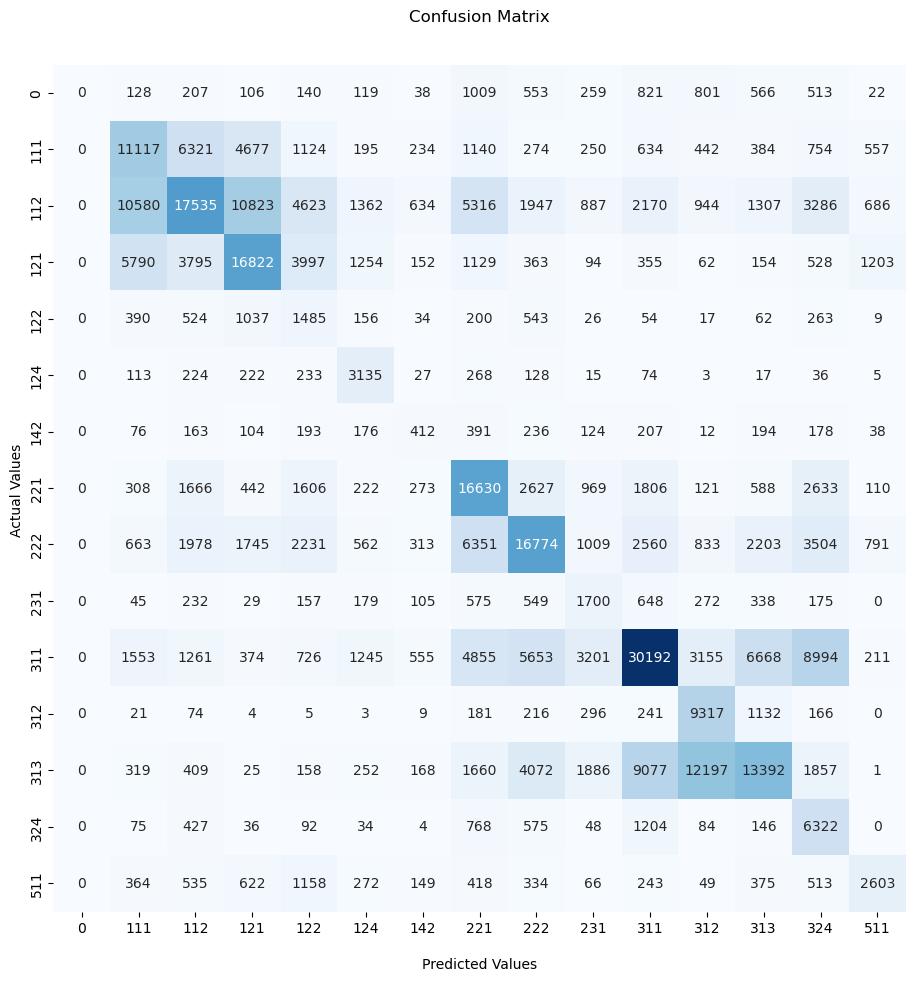

In [175]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the predictions
# y_pred = pipeline.predict(X_test)

# Calculate the confusion matrix
cf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

import seaborn as sns

plt.figure(figsize=(11, 11))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt = '.0f', cbar = False)

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(np.unique(y_true))
ax.yaxis.set_ticklabels(np.unique(y_true))

## Display the visualization of the Confusion Matrix.
plt.show()

In [106]:
# Store the result in a geotiff
predicted.rio.to_raster("predicted_2.tif")

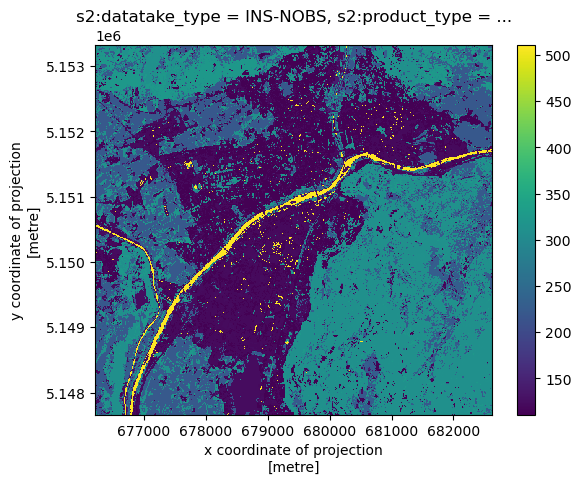

In [104]:
# Visualize the result
predicted.plot.imshow()